In [1]:
import numpy as np 
import pandas as pd 
import os 
import sys 

import librosa
import librosa.display
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
cur_path = os.getcwd()
tess_path = cur_path + '/TESS Toronto emotional speech set data/'
tess_dirs = os.listdir(tess_path)
tess_dirs

['OAF_angry',
 'OAF_disgust',
 'OAF_Fear',
 'OAF_happy',
 'OAF_neutral',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [3]:
file_emotion = []
file_path = []

for dir in tess_dirs:
    directories = os.listdir(tess_path + dir)
    for file in directories:
        part = file.split('.')[0] # without wav 
        part = part.split('_')[2] # third part represents emotion 
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess_path + dir + '/' + file)

        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df

,Emotions,Path
0,angry,C:\Users\Владелец\research/TESS Toronto emotio...
1,angry,C:\Users\Владелец\research/TESS Toronto emotio...
2,angry,C:\Users\Владелец\research/TESS Toronto emotio...
3,angry,C:\Users\Владелец\research/TESS Toronto emotio...
4,angry,C:\Users\Владелец\research/TESS Toronto emotio...
...,...,...
2795,sad,C:\Users\Владелец\research/TESS Toronto emotio...
2796,sad,C:\Users\Владелец\research/TESS Toronto emotio...
2797,sad,C:\Users\Владелец\research/TESS Toronto emotio...
2798,sad,C:\Users\Владелец\research/TESS Toronto emotio...


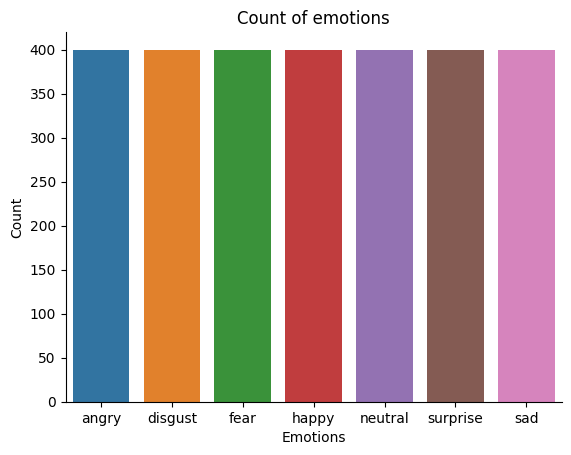

In [39]:
plt.title('Count of emotions')
sns.countplot(data=tess_df, x='Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [67]:
tess_df['Emotions'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad'],
      dtype=object)

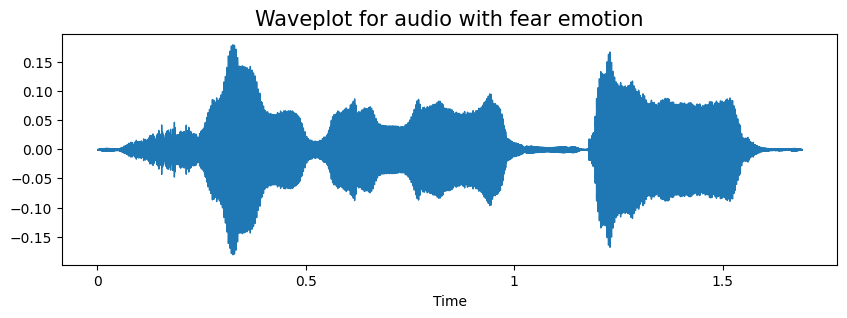

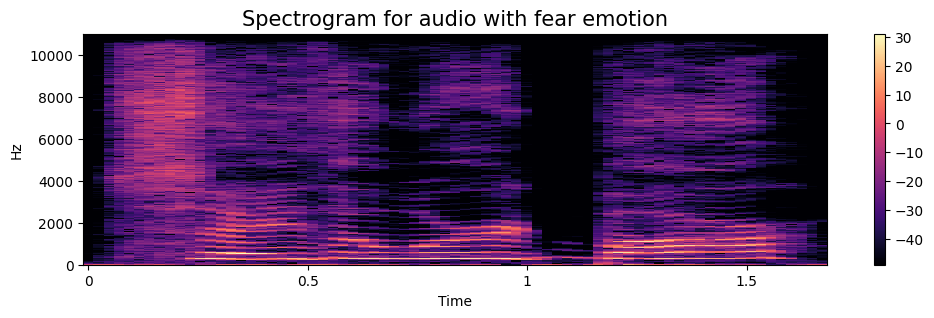

In [65]:
emotion = 'fear'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)
#print(data)
#print(sampling_rate)

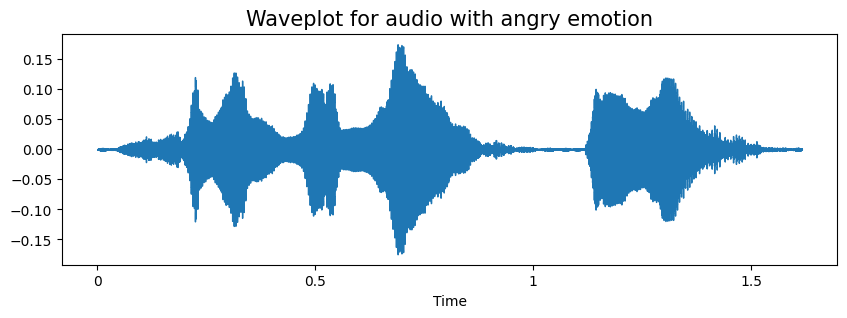

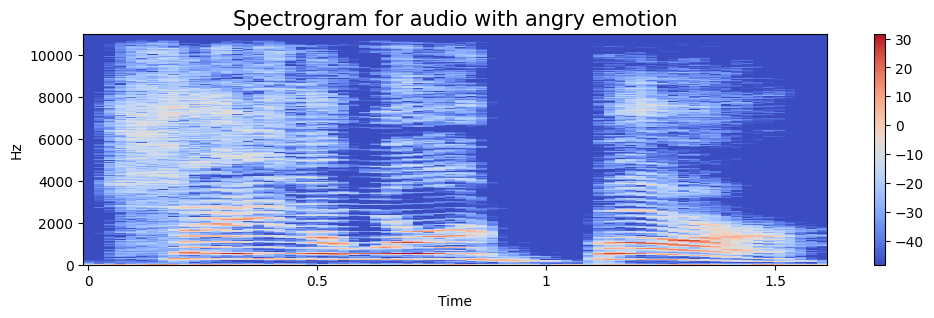

In [68]:
emotion = 'angry'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

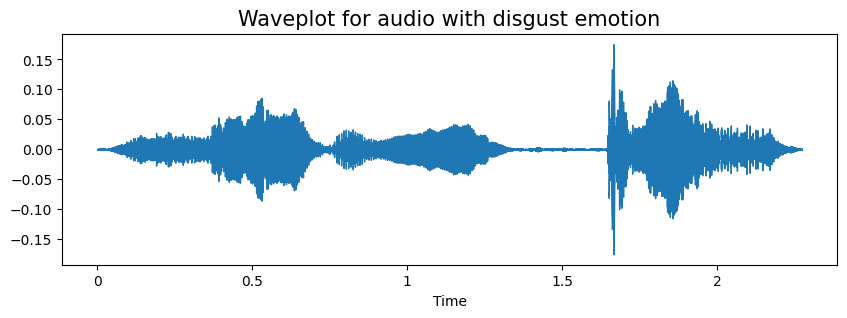

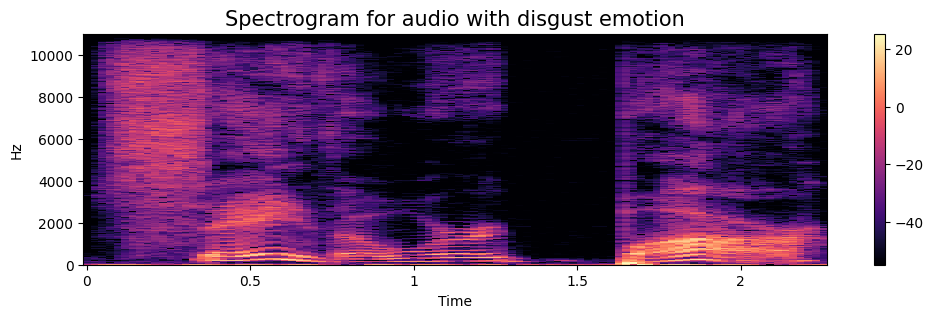

In [69]:
emotion = 'disgust'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

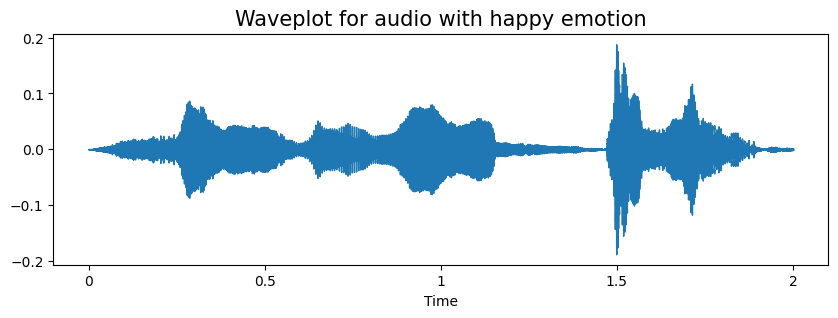

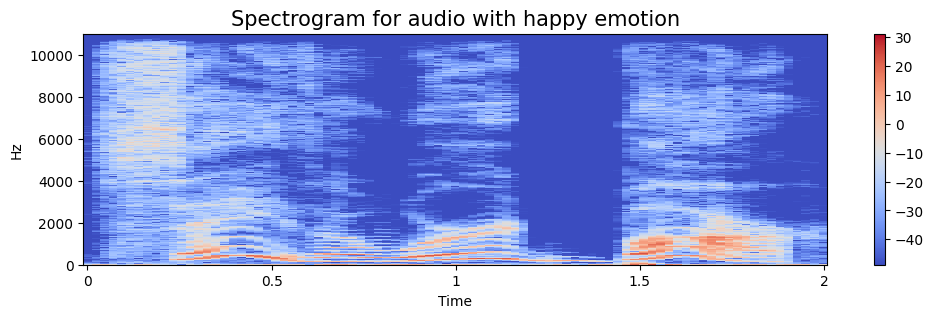

In [70]:
emotion = 'happy'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

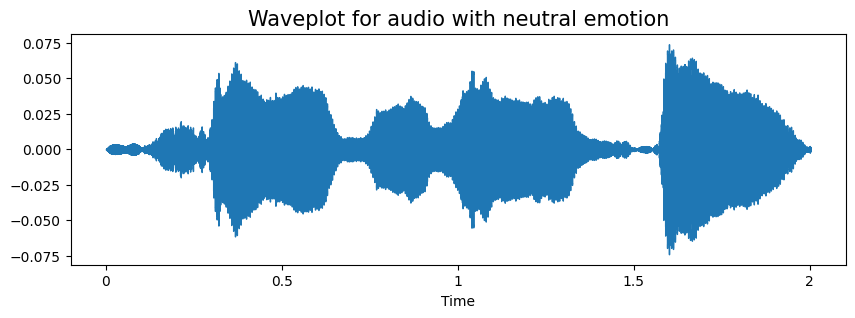

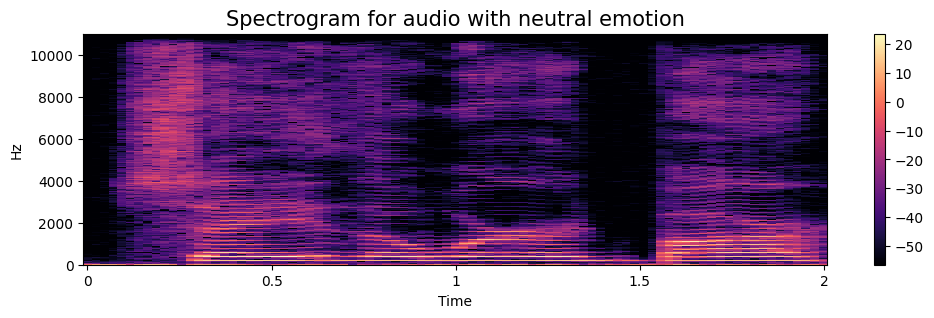

In [71]:
emotion = 'neutral'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

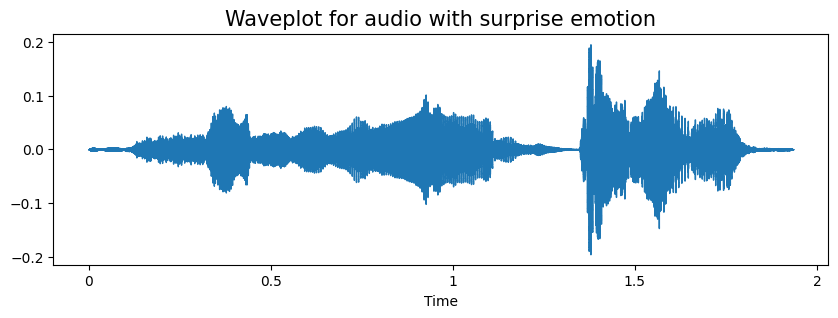

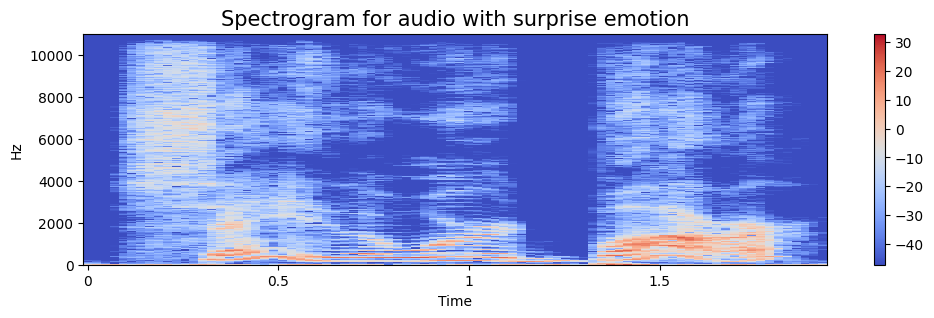

In [72]:
emotion = 'surprise'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

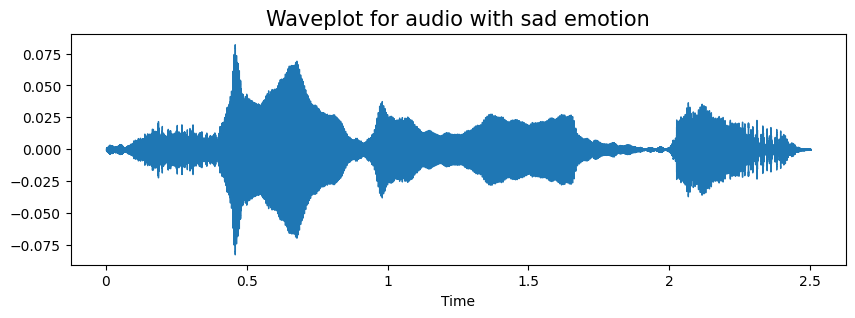

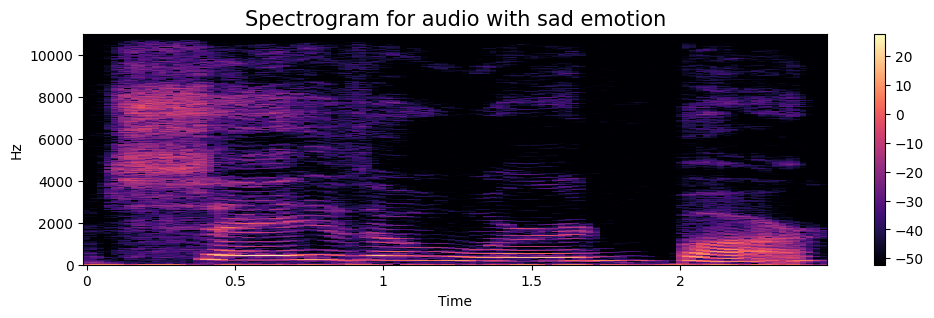

In [73]:
emotion = 'sad'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Apply noise, pitching and stretching to data

In [5]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data 

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

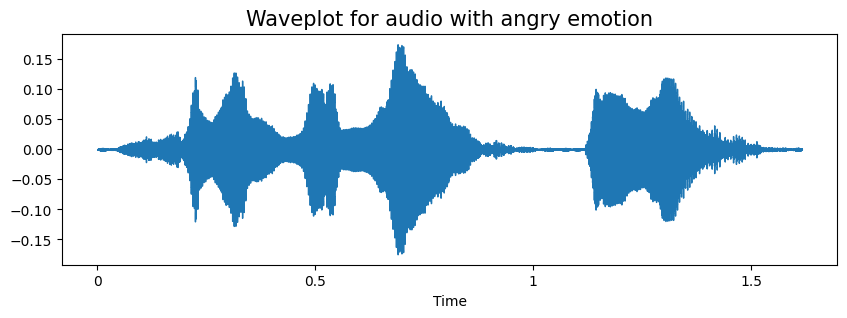

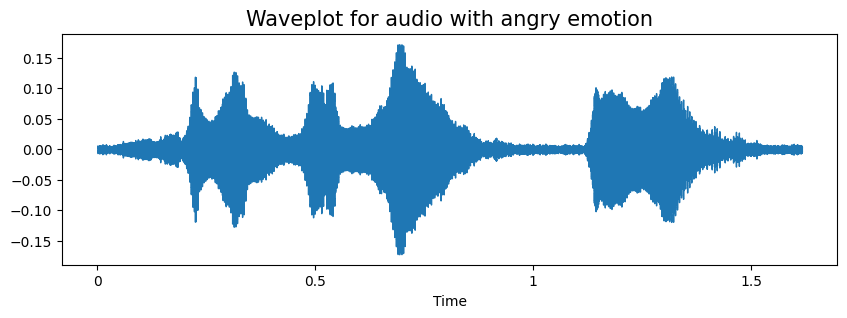

In [94]:
emotion = 'angry'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
x = noise(data)
create_waveplot(x, sampling_rate, emotion)
Audio(path, rate=sampling_rate)

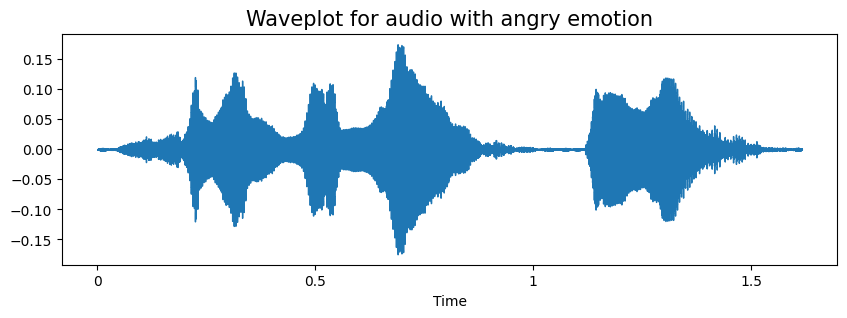

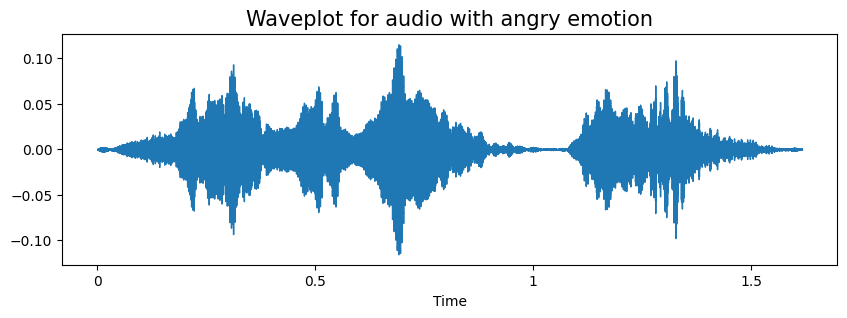

In [99]:
### Apply pitching
emotion = 'angry'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
x = pitch(data, sampling_rate)
create_waveplot(x, sampling_rate, emotion)
Audio(path)

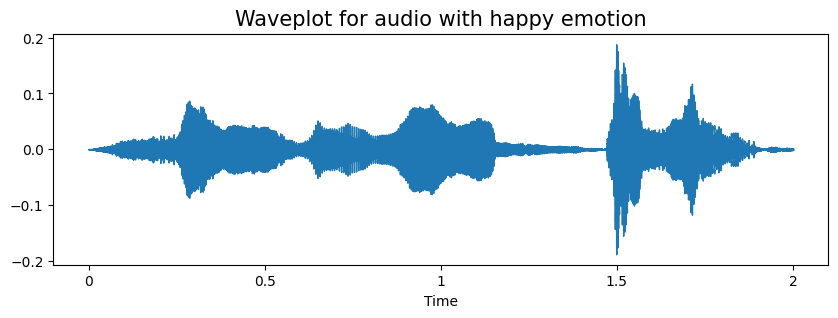

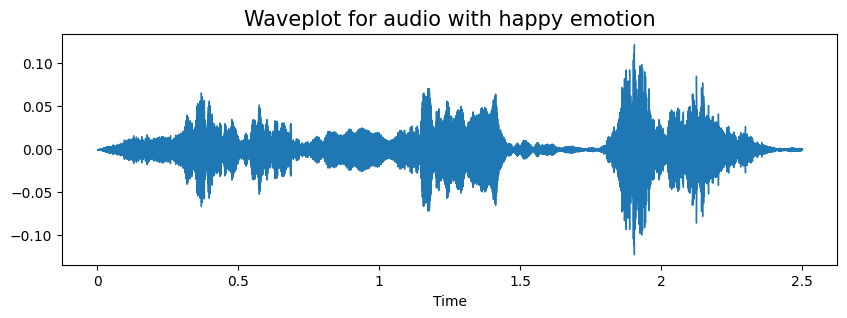

In [102]:
# apply stretching 
emotion = 'happy'
path = np.array(tess_df[tess_df['Emotions']==emotion]['Path'])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
x = stretch(data)
create_waveplot(x, sampling_rate, emotion)
Audio(path, rate=sampling_rate)

### Features extracted by 
Zero Crossing Rate,
Chroma_stft, 
MFCC, 
RMS(root mean square) value, 
MelSpectogram to train our model.

In [6]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [7]:
X, Y = [], []
for path, emotion in zip(tess_df.Path, tess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [111]:
len(X), len(Y), tess_df.Path.shape

(8400, 8400, (2800,))

In [113]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.538993,0.596808,0.396304,0.364695,0.441099,0.413557,0.373404,0.568096,0.573010,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250596e-06,angry
1,0.184046,0.654752,0.728432,0.555314,0.513594,0.574521,0.564548,0.462324,0.620786,0.676477,...,0.000663,0.000755,0.000818,0.000760,0.000742,0.000687,0.000642,0.000704,7.176840e-04,angry
2,0.073797,0.544294,0.592736,0.374034,0.335802,0.388968,0.397714,0.296938,0.535089,0.623333,...,0.000029,0.000026,0.000024,0.000037,0.000041,0.000037,0.000024,0.000007,3.829803e-07,angry
3,0.058006,0.635519,0.406851,0.370775,0.404711,0.507197,0.455434,0.395454,0.421722,0.353537,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260864e-07,angry
4,0.179088,0.773638,0.617123,0.516042,0.514993,0.577865,0.519163,0.432659,0.473295,0.461912,...,0.000472,0.000428,0.000365,0.000340,0.000352,0.000340,0.000357,0.000326,3.157480e-04,angry


In [115]:
X = Features.iloc[:, :-1].values
y = Features['labels'].values

In [117]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [141]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [142]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, X_test.shape

((6300, 162, 1), (2100, 162, 1))

In [125]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

In [131]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/50
99/99 [==============================] - 17s 176ms/step - loss: 0.8003 - accuracy: 0.7137 - val_loss: 0.3799 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 18s 180ms/step - loss: 0.5000 - accuracy: 0.8273 - val_loss: 0.2739 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 17s 175ms/step - loss: 0.4083 - accuracy: 0.8602 - val_loss: 0.2435 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 17s 172ms/step - loss: 0.3081 - accuracy: 0.8925 - val_loss: 0.1550 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 17s 171ms/step - loss: 0.2484 - accuracy: 0.9186 - val_loss: 0.1327 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - 18s 178ms/step - loss: 0.2003 - accuracy: 0.9290 - val_loss: 0.1241 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 7/50
99/99 [==============================] - 17s 174ms/st

66/66 [==============================] - 2s 25ms/step - loss: 0.0633 - accuracy: 0.9838
Accuracy of our model on test data :  98.38095307350159 %


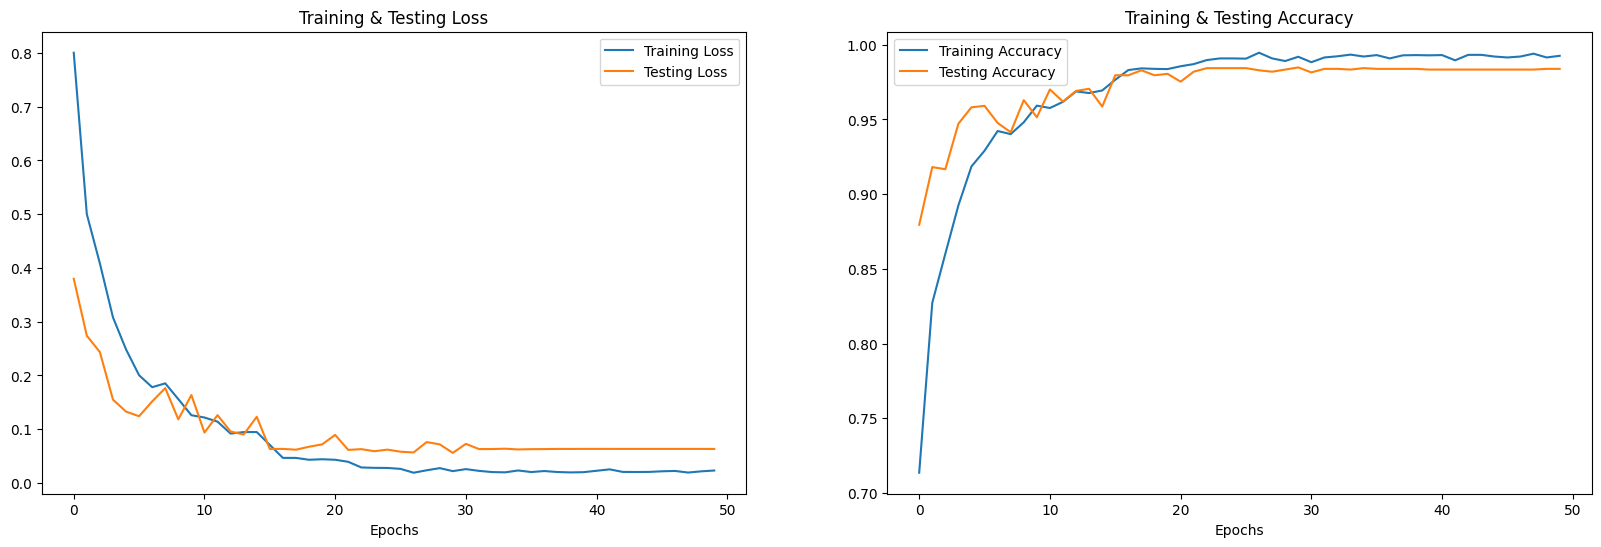

In [133]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [143]:
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 2s 25ms/step
[['neutral']
 ['angry']
 ['sad']
 ...
 ['disgust']
 ['neutral']
 ['angry']]


In [136]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,angry,angry
2,sad,sad
3,disgust,disgust
4,disgust,disgust
5,disgust,disgust
6,disgust,disgust
7,disgust,disgust
8,fear,fear
9,surprise,surprise


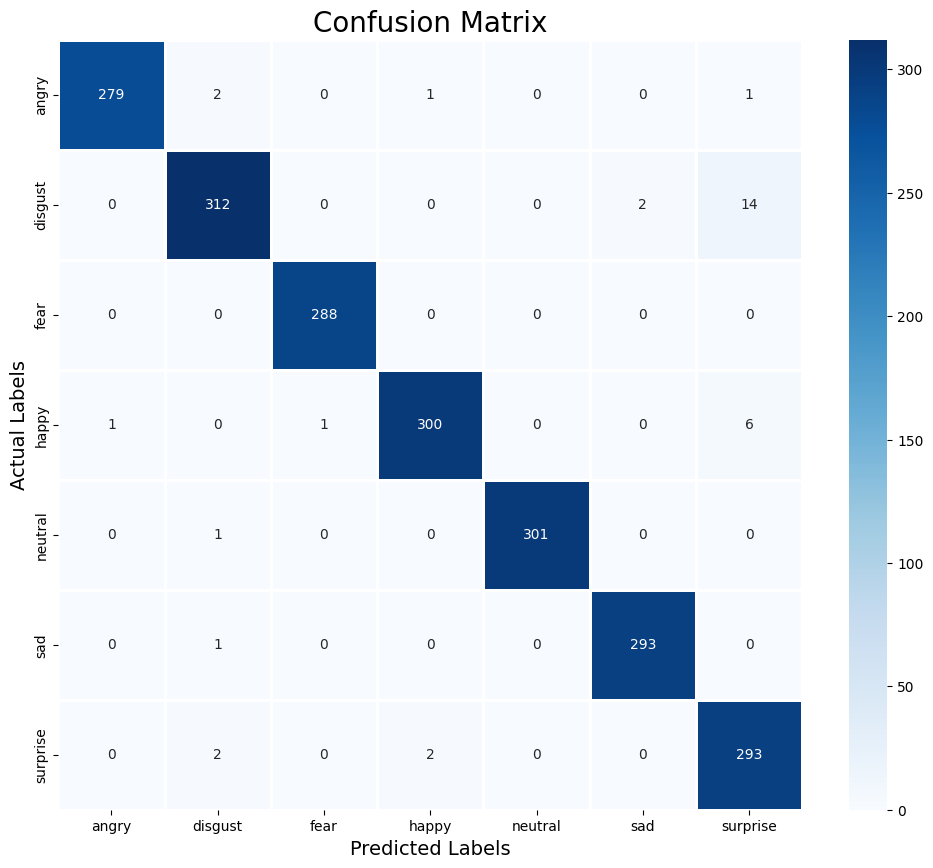

In [137]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       283
     disgust       0.98      0.95      0.97       328
        fear       1.00      1.00      1.00       288
       happy       0.99      0.97      0.98       308
     neutral       1.00      1.00      1.00       302
         sad       0.99      1.00      0.99       294
    surprise       0.93      0.99      0.96       297

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



In [144]:
model.save('audio.h5')

In [ ]:
from tensorflow.keras.models import load_model 

model = load_model('audio.h5')